In [1]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Graph neural networks for spatially-aware node regression

**Author:** Ji Won Park (@jiwoncpark)

**Last updated:** 3/02/2020

**Created:** 3/02/2020

Refer to the tutorial "Multi-target regression" for a description and visualization of our toy graph data, defined in `regression_dataset.py`. 

## Datasets and dataloaders

In [2]:
from regression_dataset import ToyDataset
from torch_geometric.data import DataLoader
train_dataset = ToyDataset(root='.', size=10000, seed=123)
val_dataset = ToyDataset(root='.', size=100, seed=456)
val_dataset.mean_std = train_dataset.mean_std
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=4, drop_last=True)

Processing...
Done!
Processing...
Done!


## Training various models on isotropically generated labels

We'll train both isotropic and anisotropic architectures on our labels, which are generated by weighting all neighboring nodes equally. Regular GCN-type network and GraphSage network are isotropic. GAT (graph attention network) is anisotropic. We expect the isotropic networks to do no worse than anisotropic ones.

In [5]:
import torch
import torch.nn as nn
from torch import optim
import losses
import gnn
from tqdm import tqdm

def train_model(model_name):
    mean, std = train_dataset.mean_std
    results = {}
    device = torch.device('cuda')
    nll_loss = getattr(losses, 'FullRankGaussianNLL')(Y_dim=3, device=device)
    model = getattr(gnn, model_name)(in_channels=3, out_channels=nll_loss.out_dim, hidden_channels=32,
                                     dropout=0.05) # MC dropout
    optimizer = optim.Adam(model.parameters(), lr=1.e-4, weight_decay=1e-5)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, cooldown=0, min_lr=1e-5, verbose=False)
    def train_single_epoch(epoch_i):
        total_loss = 0.0
        n_iter = 0
        for batch_i, batch in enumerate(train_loader):
            batch = batch.to(device)
            out = model(batch)
            loss = nll_loss(out, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += (loss.detach().item() - total_loss)/(1 + n_iter)
            n_iter += 1
        return total_loss
    train_loss = []
    model = model.to(device)
    model.train()
    for epoch_i in tqdm(range(300)):
        train_loss_i = train_single_epoch(epoch_i)
        lr_scheduler.step(train_loss_i)
        train_loss.append(train_loss_i)
        # print(train_loss_i)
        #if epoch_i %10 == 0:
            #print(train_loss_i)
    def validate(n_mc_dropout, n_samples, batch_size):
        model.eval()
        with torch.no_grad():
            samples = np.empty([batch_size, n_mc_dropout, n_samples, 3])
            for mc_iter in range(n_mc_dropout):
                for batch in val_loader:
                    batch = batch.to(device)
                    out = model(batch)
                    y_val = (batch.y.cpu()*std + mean).numpy()
                    val_loss = nll_loss(out, batch.y).item()
                    nll_loss.set_trained_pred(out)
                    mc_samples = nll_loss.sample(mean, std, n_samples, sample_seed=1113)  # [batch_size, n_samples, 3]
                    break
                samples[:, mc_iter, :, :] = mc_samples
        return samples, y_val, val_loss
    samples, y_val, val_loss = validate(20, 500, batch_size=100)  # batch_size must match val_loader batch size
    results = {'y_val': y_val, 'train_loss': train_loss, 'val_loss': val_loss, 'val_samples': samples}
    return results

In [6]:
# Takes 6.5min per architecture, except GravNet which takes 50min with default settings
experiment = {}
for arch in ['GCNNet', 'GATNet', 'SageNet']:  # , 'GravNet']
    experiment[arch] = train_model(arch)

  0%|          | 0/300 [00:00<?, ?it/s]

GCNNet


  0%|          | 0/300 [00:00<?, ?it/s]

GATNet


  0%|          | 0/300 [00:00<?, ?it/s]

SageNet


100%|██████████| 300/300 [06:45<00:00,  1.35s/it]


We'll now plot the posterior for a single validation example against the training distribution.

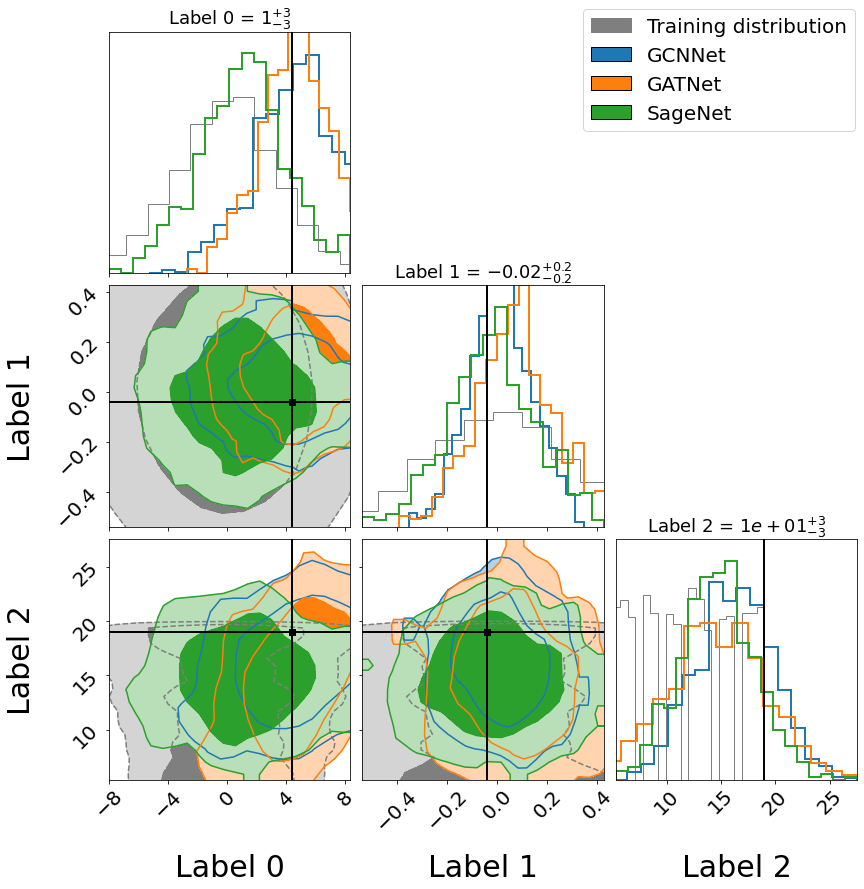

In [7]:
from plotting import plot_corner
# Get some training labels
mean, std = train_dataset.mean_std
dummy_train_loader = DataLoader(train_dataset, batch_size=5000, shuffle=True, num_workers=0, drop_last=True)
for batch in dummy_train_loader:
    y_train = (batch.y.cpu()*std + mean).numpy()
example_i = 0
fig = None
colors = {'GCNNet': 'tab:blue', 'GATNet': 'tab:orange', 'SageNet': 'tab:green'} #, 'GravNet': 'tab:purple'}
legend_elements = []
for i, (k, v) in enumerate(experiment.items()):
    pred_i = v['val_samples'][example_i, :, :, :].reshape(-1, 3)
    truth_i = v['y_val'][example_i, :]
    plot_prior = True if i == 0 else False
    fig, leg = plot_corner(pred_i, truth_i, plot_prior=plot_prior, fig=fig,
                           training_samples=y_train, 
                           posterior_label=k, posterior_color=colors[k])
    legend_elements += leg
fig.legend(handles=legend_elements, fontsize=20)

What's the recovery performance on the validation set as a whole?

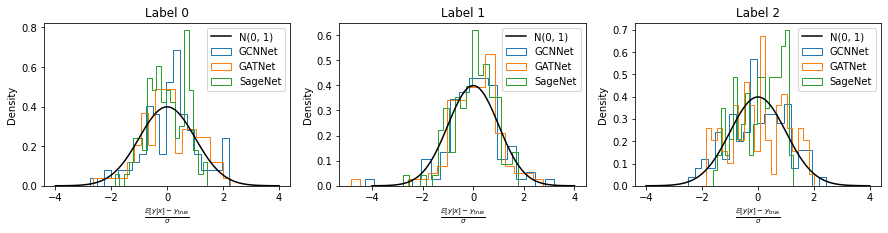

In [8]:
from scipy.stats import norm
plt.close('all')
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for target_i in range(3):
    for i, (k, v) in enumerate(experiment.items()):
        # Some reshaping gymnastics to get the mean, std 
        # across the predictive posterior samples for each validation example 
        reordered_samples = v['val_samples'].transpose(0, 3, 1, 2).reshape([100, 3, -1])
        mean_pred = np.mean(reordered_samples, axis=-1)  # [100, 3]
        std_pred = np.std(reordered_samples, axis=-1)  # [100, 3]
        y_val = v['y_val']
        z = (mean_pred - y_val)/std_pred
        axes[target_i].hist(z[:, target_i], density=True, 
                            bins=20, histtype='step', color=colors[k], label=k)
    axes[target_i].plot(np.linspace(-4, 4, 100), 
                        norm.pdf(np.linspace(-4, 4, 100)), color='k', label=r'N(0, 1)')
    axes[target_i].set_title('Label {:d}'.format(target_i))
    axes[target_i].set_xlabel(r'$\frac{\mathbb{E}[y|x] - y_{\rm true}}{\sigma}$')
    axes[target_i].set_ylabel('Density')
    axes[target_i].legend()
fig.savefig('posterior_isotropic_1d_calibration.png')

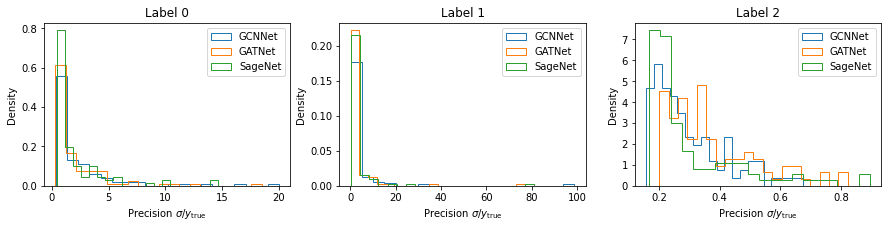

In [10]:
from scipy.stats import norm
plt.close('all')
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for target_i in range(3):
    for i, (k, v) in enumerate(experiment.items()):
        # Some reshaping gymnastics to get the mean, std 
        # across the predictive posterior samples for each validation example 
        reordered_samples = v['val_samples'].transpose(0, 3, 1, 2).reshape([100, 3, -1])
        #mean_pred = np.mean(reordered_samples, axis=-1)  # [100, 3]
        std_pred = np.std(reordered_samples, axis=-1)  # [100, 3]
        y_val = v['y_val']
        frac_precision = np.abs(std_pred/(y_val + 1.e-7))[:, target_i]
        axes[target_i].hist(frac_precision, density=True, 
                            bins=20, histtype='step', color=colors[k], label=k)
    axes[target_i].set_title('Label {:d}'.format(target_i))
    axes[target_i].set_xlabel(r'Precision $\sigma/y_{\rm true}$')
    axes[target_i].set_ylabel('Density')
    axes[target_i].legend()
fig.savefig('posterior_isotropic_precision.png')

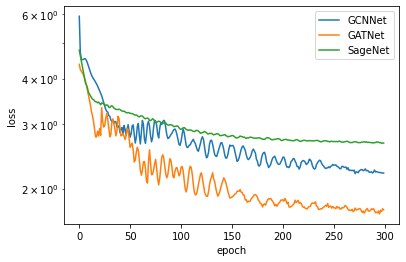

In [21]:
plt.close('all')
for i, (k, v) in enumerate(experiment.items()):
    plt.plot(v['train_loss'], label=k)
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
fig.savefig('posterior_isotropic_loss.png')

Let's export the results for later access.

In [23]:
import pickle
with open('posterior_isotropic_experiment.pickle', 'wb') as handle:
    pickle.dump(experiment, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Training various models on anisotropically generated labels

We'll now train on labels generated by excluding some nodes and assigning different weights to diferent nodes. We expect the anisotropic networks to do better than isotropic ones.

In [15]:
from regression_dataset import ToyDataset
train_dataset = ToyDataset(root='.', size=10000, seed=123, anisotropic=True)
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True, num_workers=4, drop_last=True)
val_dataset = ToyDataset(root='.', size=100, seed=456, anisotropic=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=4, drop_last=True)

Processing...
Done!
Processing...
Done!


In [54]:
# Takes 9min per architecture, except GravNet which takes ~1hr with default settings
experiment_anisotropic = {}
for arch in ['GCNNet', 'GATNet', 'SageNet']:  #, 'GravNet']:
    experiment_anisotropic[arch] = train_model(arch)

100%|██████████| 300/300 [08:38<00:00,  1.73s/it]


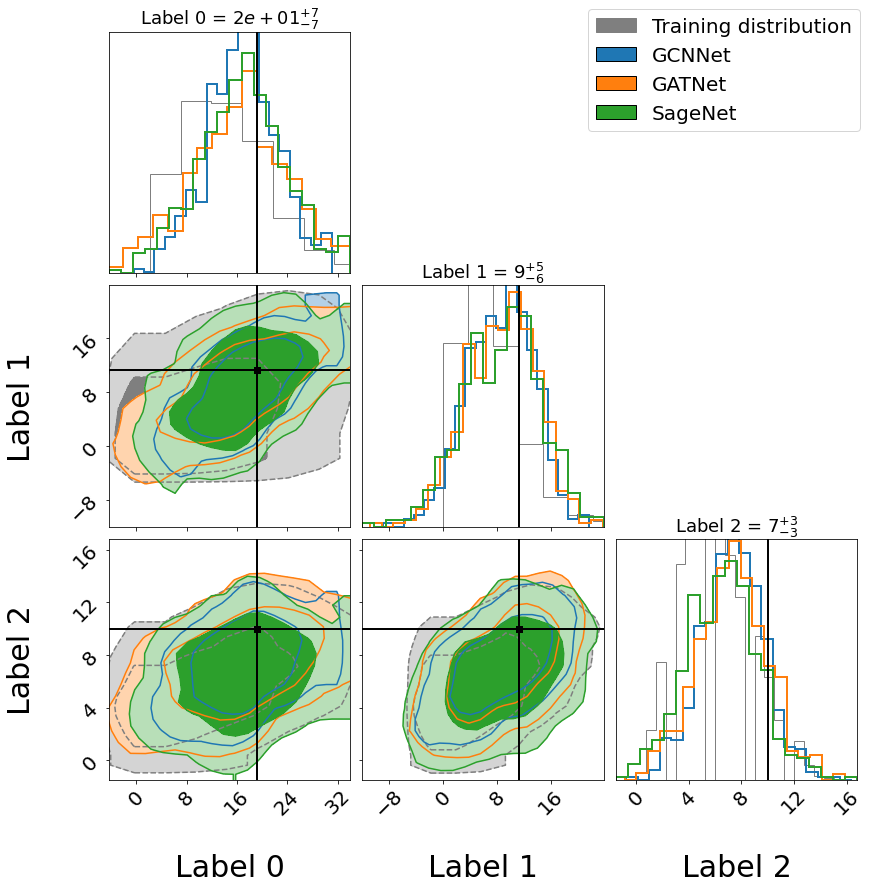

In [56]:
from plotting import plot_corner
# Get some training labels
mean, std = train_dataset.mean_std
dummy_train_loader = DataLoader(train_dataset, batch_size=5000, shuffle=True, num_workers=0, drop_last=True)
for batch in dummy_train_loader:
    y_train = (batch.y.cpu()*std + mean).numpy()
example_i = 0
fig = None
colors = {'GCNNet': 'tab:blue', 'GATNet': 'tab:orange', 'SageNet': 'tab:green', 'GravNet': 'tab:purple'}
legend_elements = []
for i, (k, v) in enumerate(experiment_anisotropic.items()):
    pred_i = v['val_samples'][example_i, :, :, :].reshape(-1, 3)
    truth_i = v['y_val'][example_i, :]
    plot_prior = True if i == 0 else False
    fig, leg = plot_corner(pred_i, truth_i, plot_prior=plot_prior, fig=fig,
                           training_samples=y_train, 
                           posterior_label=k, posterior_color=colors[k])
    legend_elements += leg
fig.legend(handles=legend_elements, fontsize=20)
fig.savefig('posterior_anistropic.png')

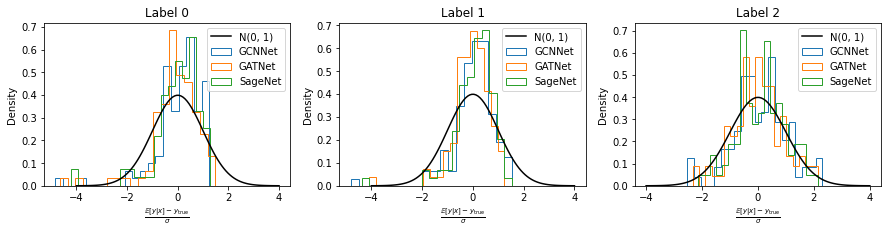

In [57]:
from scipy.stats import norm
plt.close('all')
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for target_i in range(3):
    for i, (k, v) in enumerate(experiment_anisotropic.items()):
        # Some reshaping gymnastics to get the mean, std 
        # across the predictive posterior samples for each validation example 
        reordered_samples = v['val_samples'].transpose(0, 3, 1, 2).reshape([100, 3, -1])
        mean_pred = np.mean(reordered_samples, axis=-1)  # [100, 3]
        std_pred = np.std(reordered_samples, axis=-1)  # [100, 3]
        y_val = v['y_val']
        z = (mean_pred - y_val)/std_pred
        axes[target_i].hist(z[:, target_i], density=True, 
                            bins=20, histtype='step', color=colors[k], label=k)
    axes[target_i].plot(np.linspace(-4, 4, 100), 
                        norm.pdf(np.linspace(-4, 4, 100)), color='k', label=r'N(0, 1)')
    axes[target_i].set_title('Label {:d}'.format(target_i))
    axes[target_i].set_xlabel(r'$\frac{\mathbb{E}[y|x] - y_{\rm true}}{\sigma}$')
    axes[target_i].set_ylabel('Density')
    axes[target_i].legend()
fig.savefig('posterior_anisotropic_1d_calibration.png')

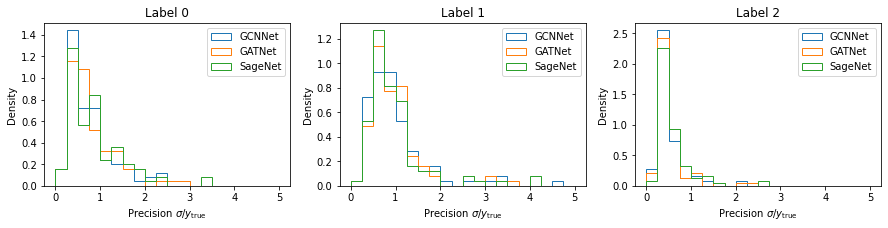

In [17]:
from scipy.stats import norm
plt.close('all')
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for target_i in range(3):
    for i, (k, v) in enumerate(experiment_anisotropic.items()):
        # Some reshaping gymnastics to get the mean, std 
        # across the predictive posterior samples for each validation example 
        reordered_samples = v['val_samples'].transpose(0, 3, 1, 2).reshape([100, 3, -1])
        #mean_pred = np.mean(reordered_samples, axis=-1)  # [100, 3]
        std_pred = np.std(reordered_samples, axis=-1)  # [100, 3]
        y_val = v['y_val']
        frac_precision = np.abs(std_pred/(y_val + 1.e-7))[:, target_i]
        axes[target_i].hist(frac_precision, density=True, 
                            bins=20, histtype='step', color=colors[k], range=[0, 5], label=k)
    axes[target_i].set_title('Label {:d}'.format(target_i))
    axes[target_i].set_xlabel(r'Precision $\sigma/y_{\rm true}$')
    axes[target_i].set_ylabel('Density')
    axes[target_i].legend()
fig.savefig('posterior_anisotropic_precision.png')

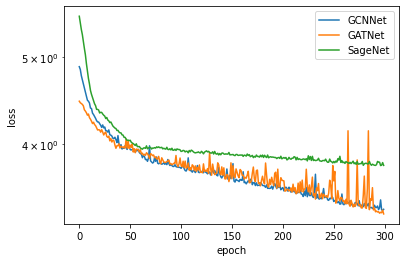

In [62]:
plt.close('all')
for i, (k, v) in enumerate(experiment_anisotropic.items()):
    plt.plot(v['train_loss'], label=k)
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
fig.savefig('posterior_anisotropic_loss.png')

In [63]:
with open('posterior_anisotropic_experiment.pickle', 'wb') as handle:
    pickle.dump(experiment_anisotropic, handle, protocol=pickle.HIGHEST_PROTOCOL)

You can access the pickled info later by running:

In [13]:
import pickle
with open(r"posterior_anisotropic_experiment.pickle", "rb") as f:
    experiment_anisotropic = pickle.load(f)